In [1]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
from copy import deepcopy

In [2]:
#загрузка данных mnist
def load_mnist(path):
    with open(path, mode='rb') as f:
        training_data, _, test_data = pickle.load(f, encoding='bytes')
        return dict(
            training_images = training_data[0],
            training_labels = training_data[1],
            test_images = test_data[0],
            test_labels = test_data[1]
        )

In [3]:
#отрисовка цифр
def draw_mnist_digit(mnist, example):
    label = mnist['training_labels'][example]
    plt.title('Example: %d, label: %d' % (example, label))
    plt.imshow(np.array(mnist['training_images'][7]).reshape((28, 28)), cmap=plt.get_cmap('gray'))
    plt.show()

In [4]:
#метод градиентного спуска
class GradientDescent():
    def __init__(self, learning_rate):
        self.learning_rate = learning_rate

    def init_model(self, model):
        self.model = model

    def update(self, grad_w, grad_b):
        for i in range(len(self.model.layers) - 1, 0, -1):
            self.model.weights[i] -= self.learning_rate * grad_w[i]
            self.model.biases[i] -= self.learning_rate * grad_b[i]

    def __str__(self):
        return 'Gradient Descent'

In [5]:
#метод Флечера-Ривза
class ConjugateGradientFR():
    def __init__(self, learning_rate):
        self.learning_rate = learning_rate

    def init_model(self, model):
        self.model = model
        self.prev_grad_w = None
        self.previous_d = None

    def update(self, grad_w, grad_b):
        if self.previous_d is None:
            self.previous_d = [-grad_w[i] for i in range(1, len(self.model.layers))]
        else:
            beta = [np.zeros((grad_w[i].shape[0], 1)) for i in range(1, len(self.model.layers))]
            for i in range(1, len(self.model.layers)):
                numerator = np.linalg.norm(grad_w[i]) ** 2
                denominator = np.linalg.norm(self.prev_grad_w[i]) ** 2
                beta[i - 1] = numerator / (denominator + 1e-100)
                beta[i - 1] = np.where(beta[i - 1] < 1, beta[i - 1], 1)
            self.previous_d = [-grad_w[i] + beta[i - 1] * self.previous_d[i - 1] for i in range(1, len(self.model.layers))]
        for i in range(1, len(self.model.layers)):
            self.model.weights[i] += self.learning_rate * self.previous_d[i - 1]
            self.model.biases[i] -= self.learning_rate * grad_b[i]
        self.prev_grad_w = grad_w

    def __str__(self):
        return 'Conjugate Gradient FR'


In [6]:
#метод Бройдена-Флетчера-Гольдфарба-Шенно
class BFGS():
    def __init__(self, learning_rate):
        self.learning_rate = learning_rate

    def init_model(self, model):
        self.model = model
        self.H = [None] + [np.eye(self.model.weights[i].shape[0]) for i in range(1, len(self.model.layers))]
        self.prev_grad_w = [None] + [np.zeros_like(self.model.weights[i]) for i in range(1, len(self.model.layers))]
        self.prev_weights = [None] + [np.zeros_like(self.model.weights[i]) for i in range(1, len(self.model.layers))]

    def update(self, grad_w, grad_b):
        for i in range(1, len(self.model.layers)):
            delta_w = -self.learning_rate * np.dot(self.H[i], grad_w[i])
            delta_b = -self.learning_rate * grad_b[i]
            self.model.weights[i] += delta_w
            self.model.biases[i] += delta_b

            delta_grad_w_i = grad_w[i] - self.prev_grad_w[i]
            delta_weight_i = self.model.weights[i] - self.prev_weights[i]

            rho = 1.0 / (np.dot(delta_weight_i, np.transpose(delta_grad_w_i)) + 1e-100)
            rho = np.where((rho > 0) & (rho < 1) , rho, 0)
            self.H[i] = (np.eye(self.model.weights[i].shape[0]) - rho * np.dot(delta_weight_i, np.transpose(delta_grad_w_i))) * self.H[i] * (np.eye(self.model.weights[i].shape[0]) - rho * np.dot(delta_grad_w_i,np.transpose(delta_weight_i))) + rho * np.dot(delta_weight_i,np.transpose(delta_weight_i))
        self.prev_grad_w = grad_w
        self.prev_weights = deepcopy(self.model.weights)

    def __str__(self):
        return 'BFGS'

In [7]:
#класс персептрона
class Perceptron:
    def __init__(self, layers, optimizer):
        # layers-- это кортеж, каждый элемент которого
        # представляет количество нейронов в соответствующем слое
        self.layers = layers
        self.weights = [None]
        self.biases = [None]
        # инициализация весов и смещений в каждом слое
        # для входного слоя веса и смещения не нужны
        for i in range(1, len(self.layers)):
            self.weights.append(np.random.uniform(-1, 1, (self.layers[i], self.layers[i - 1])) * np.sqrt(1 / layers[i - 1]))
            self.biases.append(np.random.uniform(-1, 1, self.layers[i]).reshape(self.layers[i], 1))
        self.optimizer = optimizer
        self.optimizer.init_model(self)
        
    #описание функций активации релу и софтмакс
    @staticmethod
    def relu(x):
        return np.vectorize(lambda x: x if x >= 0 else 0)(x)

    @staticmethod
    def softmax(x):
        return np.exp(x - max(x)) / np.sum(np.exp(x - max(x)))

    def activate(self, x, activation):
        if activation not in ('relu', 'softmax'):
            raise Exception('activation should be "relu" or "softmax"')
        if activation == 'relu':
            return self.relu(x)
        return self.softmax(x)

    def activation_func_derivative(self, x, activation):
        if activation not in ('relu', 'softmax'):
            raise Exception('activation should be "relu" or "softmax"')
        if activation == 'relu':
            return np.vectorize(lambda x: 1 if x >= 0 else 0)(x)
        return self.activate(x, 'softmax') * (1 - self.activate(x, 'softmax'))

    def feedforward(self, input):
        weighted_inputs, outputs = [None], [input]
        for i in range(1, len(self.layers)):
            weighted_input = np.dot(self.weights[i], outputs[i - 1]) + self.biases[i]
            output = self.activate(weighted_input, 'relu') if i != len(self.layers) - 1 else self.activate(weighted_input, 'softmax')
            weighted_inputs.append(weighted_input)
            outputs.append(output)
        return (weighted_inputs, outputs)

    # средняя квадратичная ошибка
    @staticmethod
    def mean_squared_error(expected, predicted):
        return np.mean((expected - predicted) ** 2)

    # категориальная перекрёстная энтропия
    @staticmethod
    def categorial_cross_entropy(expected, predicted):
        return -np.sum(expected * np.log(predicted + 1e-100))

    # дивергенция Кульбака-Лейблера
    @staticmethod
    def kl_divergence(expected, predicted):
        return np.sum(expected * np.log((expected + 1e-100) / (predicted + 1e-100)))
    
    #обучение
    def train(self, training_data, expected_data, epochs, is_loss_funcs_plot_needed):
        training_data = training_data[:]
        x, y = [], [[], [], []]
        for epoch in range(1, epochs + 1):
            mse_loss, cross_entropy_loss, kl_loss = 0, 0, 0
            for training_image, expected_image in zip(training_data, expected_data):
                weighted_inputs, predicted_data = self.feedforward(training_image)
                errors = self.backpropogate_error(weighted_inputs, predicted_data[-1], expected_image)
                grad_w, grad_b = [None for _ in range(len(self.layers))], [None for _ in range(len(self.layers))]
                for i in range(len(self.layers) - 1, 0, -1):
                    grad_w[i] = np.dot(errors[i], np.transpose(predicted_data[i - 1]))
                    grad_b[i] = errors[i]
                self.optimizer.update(grad_w, grad_b)
                mse_loss += self.mean_squared_error(expected=expected_image, predicted=predicted_data[-1])
                cross_entropy_loss += self.categorial_cross_entropy(expected=expected_image, predicted=predicted_data[-1])
                kl_loss += self.kl_divergence(expected=expected_image, predicted=predicted_data[-1])
            mse_loss /= len(training_data)
            cross_entropy_loss /= len(training_data)
            kl_loss /= len(training_data)
            x.append(epoch)
            y[0].append(mse_loss)
            y[1].append(cross_entropy_loss)
            y[2].append(kl_loss)
        self.loss_func_values = y[0]
        if is_loss_funcs_plot_needed:
            self.plot_loss_funcs(x, y)
    
    #обратное распространение ошибки
    def backpropogate_error(self, weighted_inputs, predicted_data, expected_data):
        errors = [None for _ in self.layers]
        errors[-1] = predicted_data - expected_data
        for i in range(len(self.layers) - 2, 0, -1):
            errors[i] = np.dot(np.transpose(self.weights[i + 1]), errors[i + 1]) * self.activation_func_derivative(weighted_inputs[i], 'relu')
        return errors
    
    #предсказание
    def predict(self, test_data):
        score = 0
        max_score = 0
        for data, expected_label in test_data:
            predicted_label = np.argmax(self.feedforward(data)[1][-1])
            score = score + 1 if predicted_label == expected_label else score
            max_score += 1
        return score / max_score * 100

    def plot_loss_funcs(self, x, y):
        for i, label in enumerate(['mean_squared_error', 'cross_entropy_loss', 'kl_loss']):
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.plot(x, y[i], label=label, c='red')
            plt.legend(loc='upper right')
            plt.show()

    def get_loss_values(self):
        return self.loss_func_values

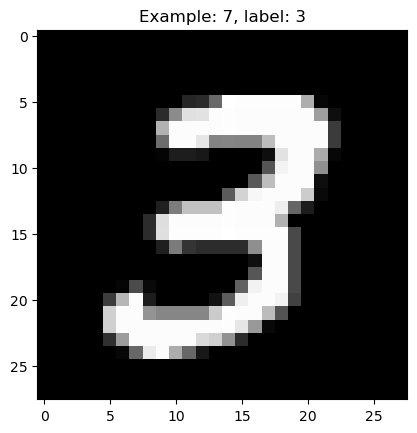

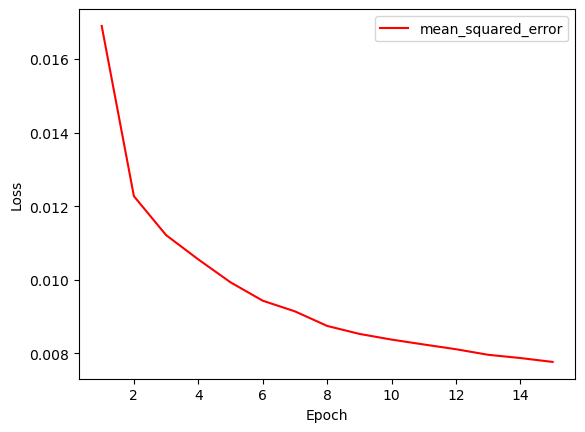

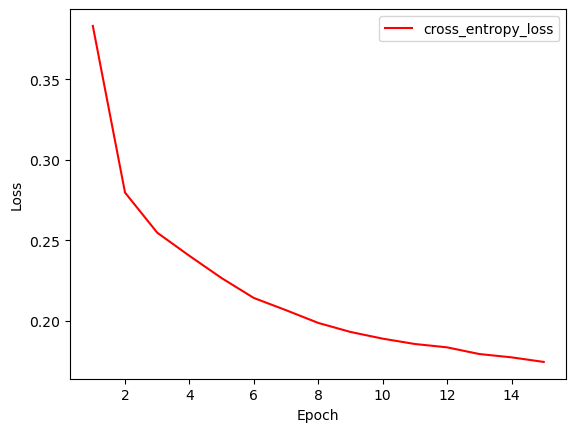

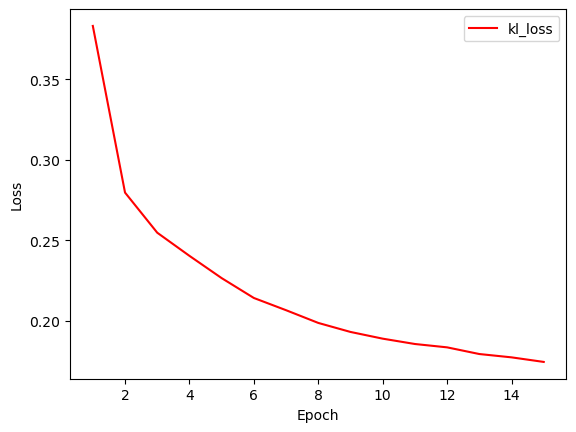

Accuracy of guessed numbers: 92.53%


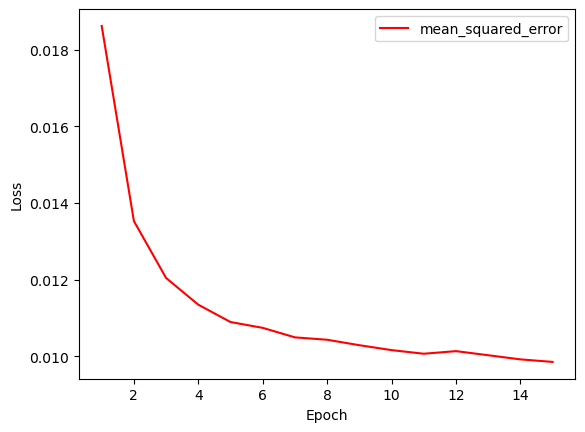

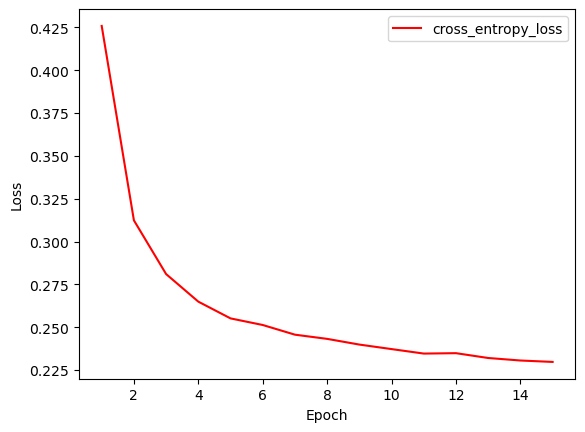

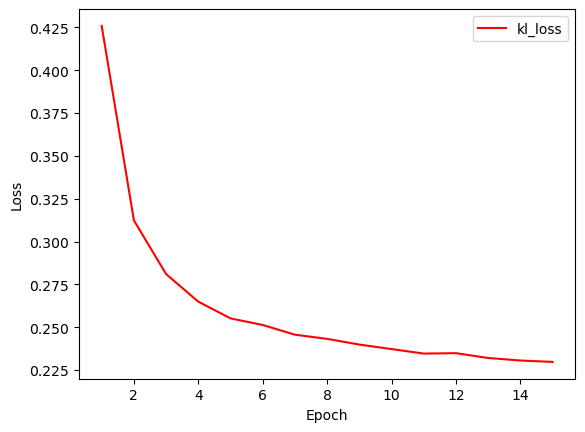

Optimization method: Gradient Descent
Accuracy of guessed numbers: 92.07%


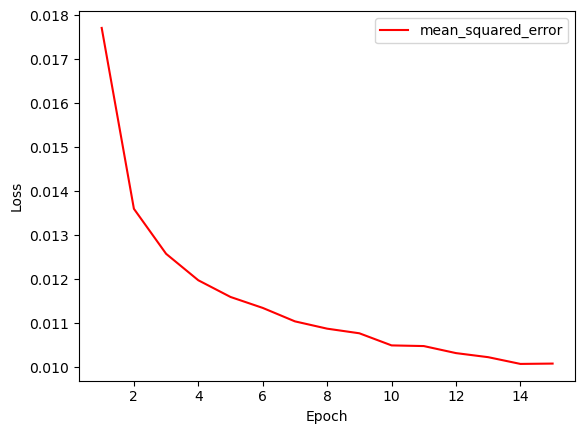

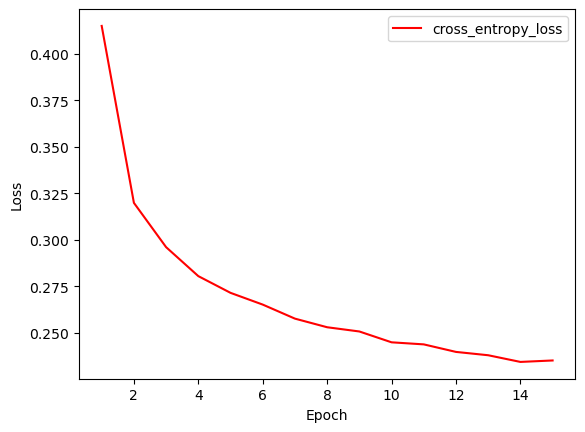

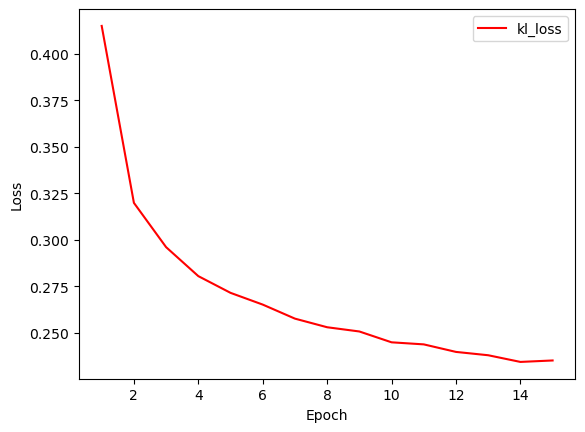

Optimization method: Conjugate Gradient FR
Accuracy of guessed numbers: 92.33%


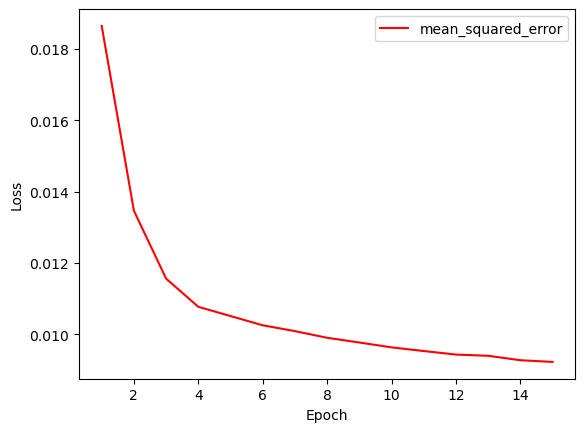

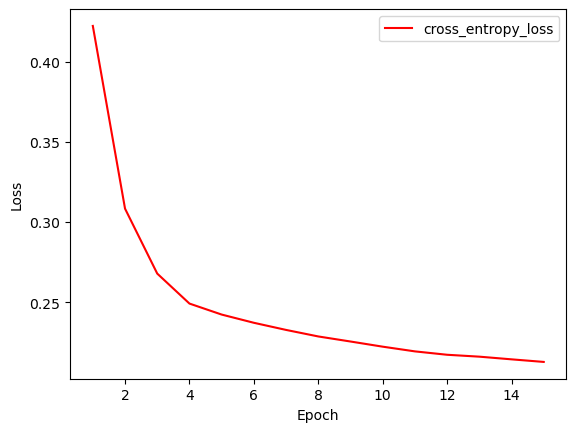

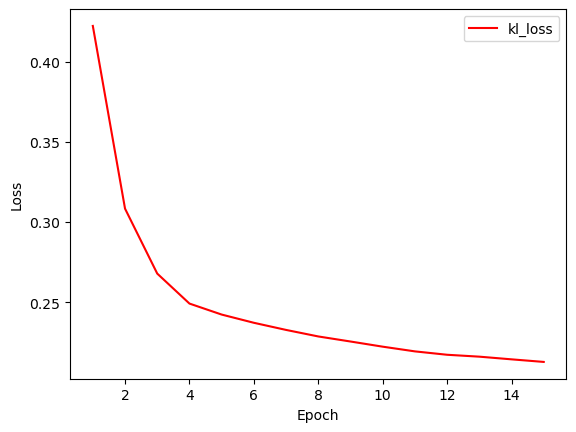

Optimization method: BFGS
Accuracy of guessed numbers: 90.75%


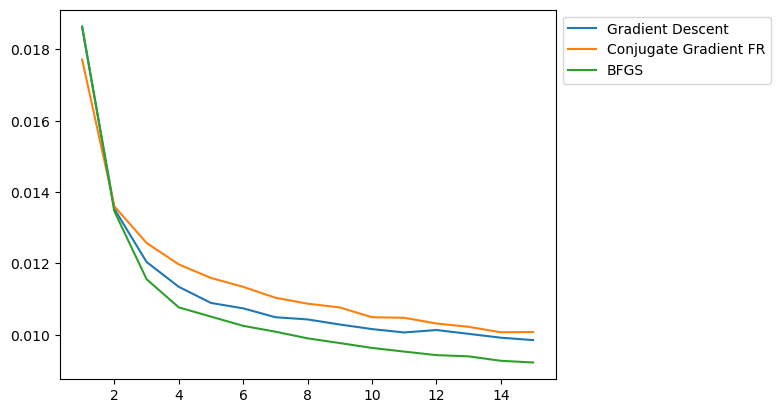

In [8]:
#тестирование персептрона
mnist = load_mnist('mnist.pkl')
draw_mnist_digit(mnist, example=7)

training_data = np.array([np.reshape(x, (784, 1)) for x in mnist['training_images']])
expected_data = np.array([[[1.0] if i == label else [0] for i in range(10)] for label in mnist['training_labels']])
test_data = zip(np.array([np.reshape(x, (784, 1)) for x in mnist['test_images']]), mnist['test_labels'])

epochs = 15

perceptron = Perceptron(layers=(784, 15, 10), optimizer=GradientDescent(0.01))
perceptron.train(
    training_data=training_data,
    expected_data=expected_data,
    epochs=epochs,
    is_loss_funcs_plot_needed=True
)
score = perceptron.predict(test_data=deepcopy(test_data))
print(f'Accuracy of guessed numbers: {score}%')

optimizers = (
    GradientDescent(0.01),
    ConjugateGradientFR(0.01),
    BFGS(0.01)
)
y_s = list()
for optimizer in optimizers:
    perceptron = Perceptron(layers=(784, 15, 10), optimizer=optimizer)
    perceptron.train(
        training_data=training_data,
        expected_data=expected_data,
        epochs=epochs,
        is_loss_funcs_plot_needed=True
    )
    y_s.append(perceptron.get_loss_values())
    score = perceptron.predict(test_data=deepcopy(test_data))
    print(f'Optimization method: {str(optimizer)}')
    print(f'Accuracy of guessed numbers: {score}%')

for i, optimizer in enumerate(optimizers):
    x, y = range(1, epochs + 1), y_s[i]
    plt.plot(x, y, label=str(optimizer))
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.show()
